In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("projB1.ipynb")

# Project B1: Spam/Ham Classification

## Due Date: Thursday, November 16th at 11:59 PM
You must submit this assignment to Gradescope by the on-time deadline, Thursday, November 16th at 11:59 PM. 

Please read the syllabus for the grace period policy. No late submissions beyond the grace period will be accepted. While course staff is happy to help you if you encounter difficulties with submission, we may not be able to respond to last-minute requests for assistance (TAs need to sleep, after all!). 
**We strongly encourage you to plan to submit your work to Gradescope several hours before the stated deadline.** 
This way, you will have ample time to reach out to staff for submission support.

### Collaboration Policy

Data science is a collaborative activity. While you may talk with others about this project, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the collaborators cell below.

**Collaborators**: *list collaborators here*

## Introduction
You will use what you've learned in class to create a binary classifier that can distinguish spam (junk or commercial or bulk) emails from ham (regular non-spam) emails. In addition to providing some skeleton code to fill in, we will evaluate your work based on your model's accuracy and your written responses in this notebook.

After this project, you should feel comfortable with the following:

- Feature engineering with text data,
- Using the `sklearn` library to process data and fit models, and
- Validate the performance of your model and minimize overfitting.

This first part of the project focuses on initial analysis, Feature Engineering, and Logistic Regression. In the second part of this project (to be released next week), you will build your own spam/ham classifier.

## Content Warning
This is a **real-world** dataset – the emails you are trying to classify are actual spam and legitimate emails. As a result, some of the spam emails may be in poor taste or be considered inappropriate. We think the benefit of working with realistic data outweighs these inappropriate emails and wanted to give a warning at the beginning of the project so that you are made aware.

If you feel uncomfortable with this topic, **please contact your TA, the instructors, or reach out via the [extenuating circumstances form](https://docs.google.com/forms/d/e/1FAIpQLSffIhNMwsxP9Pd5l_9dzx_V4VffsNIOOjOexLT9VgUtmzw4AA/viewform).**

In [2]:
# Run this cell to suppress all FutureWarnings.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# More readable exceptions.
%pip install --quiet iwut
%load_ext iwut
%wut on

Note: you may need to restart the kernel to use updated packages.


## Grading
Grading is broken down into autograded answers and free responses. 

For autograded answers, the results of your code are compared to provided and/or hidden tests.

For free response, readers will evaluate how well you answered the question and/or fulfilled the requirements of the question.

Question | Manual | Points
----|----|----
1 | Yes | 2
2 | No | 3
3 | Yes | 3
4 | No | 2
5 | No | 2
6a | No | 1
6b | No | 1
6c | Yes | 2
6d | No | 2
6e | No | 1
6f | Yes | 1
6g | Yes | 1
6h | Yes | 2
Total | 6 | 23

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# The Data

In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. The dataset is from [SpamAssassin](https://spamassassin.apache.org/old/publiccorpus/). It consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8,348 labeled examples, and the unlabeled test set contains 1,000 unlabeled examples.

**Note:** The dataset is from 2004, so the contents of emails might be very different from those in 2023.

Run the following cells to load the data into a `DataFrame`.

The `train` `DataFrame` contains labeled data you will use to train your model. It has four columns:

1. `id`: An identifier for the training example.
1. `subject`: The subject of the email.
1. `email`: The text of the email.
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam).

The `test` `DataFrame` contains 1,000 unlabeled emails. In Project B2, you will predict labels for these emails and submit your predictions to the autograder for evaluation.

In [4]:
import zipfile
with zipfile.ZipFile('spam_ham_data.zip') as item:
    item.extractall()

In [5]:
# Loading training and test datasets
original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Convert the emails to lowercase as the first step of text processing.
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


<br/>

First, let's check if our data contains any missing values. We have filled in the cell below to print the number of `NaN` values in each column. If there are `NaN` values, we replace them with appropriate filler values (i.e., `NaN` values in the `subject` or `email` columns will be replaced with empty strings). Finally, we print the number of `NaN` values in each column after this modification to verify that there are no `NaN` values left.

**Note:** While there are no `NaN` values in the `spam` column, we should be careful when replacing `NaN` labels. Doing so without consideration may introduce significant bias into our model.

In [6]:
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


<br/>
<hr style="border: 1px solid #fdb515;" />

# Part 1: Initial Analysis

In the cell below, we have printed the text of the `email` field for the first ham and the first spam email in the original training set.

In [7]:
first_ham = original_training_data.loc[original_training_data['spam'] == 0, 'email'].iloc[0]
first_spam = original_training_data.loc[original_training_data['spam'] == 1, 'email'].iloc[0]
print("Ham Email:")
print(first_ham)
print("-------------------------------------------------")
print("Spam Email:")
print(first_spam)

Ham Email:
url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

-------------------------------------------------
Spam Email:
<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



<!-- BEGIN QUESTION -->

<br>

---

## Question 1

Discuss one attribute or characteristic you notice that is different between the two emails that might relate to the identification of a spam email.

We can see that the format used in both emails is different. While the ham email used plain text the spam email was HTML formatted with the tags indicating so

<!-- END QUESTION -->

## Training-Validation Split
The training data we downloaded is all the data we have available for both training models and **validating** the models that we train. We, therefore, need to split the training data into separate training and validation datasets. You will need this **validation data** to assess the performance of your classifier once you are finished training. Note that we set the seed (`random_state`) to 42. This will produce a pseudo-random sequence of random numbers that is the same for every student. **Do not modify this random seed in the following questions, as our tests depend on it.**

In [8]:
# This creates a 90/10 train-validation split on our labeled data.
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 42)

<br/>
<hr style="border: 1px solid #fdb515;" />

# Part 2: Feature Engineering

We want to take the text of an email and predict whether the email is ham or spam. This is a **binary classification** problem, so we can use logistic regression to train a classifier. Recall that to train a logistic regression model, we need a numeric feature matrix $\mathbb{X}$ and a vector of corresponding binary labels $Y$. Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $\mathbb{X}$ is an email. Each column of $\mathbb{X}$ contains one feature for all the emails. We'll guide you through creating a simple feature, and you'll create more interesting ones as you try to increase the accuracy of your model.

<br>

---

## Question 2

Create a function `words_in_texts` that takes in a list of interesting words (`words`) and a `Series` of emails (`texts`). Our goal is to check if each word in `words` is contained in the emails in `texts`.

The `words_in_texts` function should output a **2-dimensional `NumPy` array** that contains one row for each email in `texts` and one column for each word in `words`. If the $j$-th word in `words` is present at least once in the $i$-th email in `texts`, the output array should have a value of 1 at the position $(i, j)$. Otherwise, if the $j$-th word is not present in the $i$-th email, the value at $(i, j)$ should be 0.

In Project B2, we will be applying `words_in_texts` to some large datasets, so implementing some form of vectorization (for example, using `NumPy` arrays, `Series.str` functions, etc.) is highly recommended. **You are allowed to use a single list comprehension or for loop**, but you should look into how you could combine that with the vectorized functions discussed above. 

For example:
```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

Importantly, we **do not** calculate the *number of occurrences* of each word; only if the word is present at least once. Take a moment to work through the example on your own if need be - understanding what the function does is a critical first step in implementing it.

*The provided tests make sure that your function works correctly so that you can use it for future questions.*

In [9]:
def words_in_texts(words, texts):
    """
    Args:
        words (list): Words to find.
        texts (Series): Strings to search in.
    
    Returns:
        A 2D NumPy array of 0s and 1s with shape (n, d) where 
        n is the number of texts and d is the number of words.
    """
    indicator_array = []
    for i in texts:
        indicator_array.append([1 if word in i else 0 for word in words])
    indicator_array = np.array(indicator_array)
    return indicator_array

In [10]:
grader.check("q2")

q2 results: All test cases passed!

<br/>
<hr style="border: 1px solid #fdb515;" />

# Part 3: EDA

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. Suppose the feature is a binary indicator, such as whether a particular word occurs in the text. In that case, this compares the proportion of spam emails with the word to the proportion of ham emails with the word.

The following plot (created using `sns.barplot`) compares the proportion of emails in each class containing a particular set of words. The bars colored by email class were generated by setting the `hue` parameter of `sns.barplot` to a column containing the class (spam or ham) of each data point. An example of how this class column was created is shown below:

![training conditional proportions](images/training_conditional_proportions.png)

You can use `DataFrame`'s `.melt` ([documentation](https://pandas.pydata.org/pandas-docs/version/1.4/reference/api/pandas.melt.html)) method to "unpivot" a `DataFrame`. See the following code cell for an example.

In [11]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our Original DataFrame has a `type` column and some columns corresponding to words. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurrences of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into entries in a variable column. Notice how `word_1` and `word_2` become entries in `variable`; their values are stored in the value column."))
display(df.melt("type"))

> Our Original DataFrame has a `type` column and some columns corresponding to words. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurrences of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into entries in a variable column. Notice how `word_1` and `word_2` become entries in `variable`; their values are stored in the value column.

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


<br>

---

## Question 3

Create the bar chart above by comparing the proportion of spam and ham emails containing specific words. **Choose a set of 6 words other than those shown in the example.** These words should have different proportions for the two classes (i.e., noticeably different bar heights across spam and ham). Make sure only to consider emails from `train`. Your `words_in_texts` function from the previous part will be useful here. 

**Hint:** This is a pretty challenging question. The suggested approach is to first look at the example bar plot and make sure you can interpret what is being plotted - what does a bar represent? What does the height mean? 

Next, see how to make this plot with `sns.barplot`. Take a look at the ([documentation](https://seaborn.pydata.org/generated/seaborn.barplot.html)) and determine what the inputs should be. A possible data input is given below:
<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>type</th>      <th>variable</th>      <th>value</th>    </tr>  </thead>  <tbody>    
<tr>      <th>0</th>      <td>Ham</td>      <td>word_1</td>      <td>0.021269</td>    </tr>    
<tr>      <th>1</th>      <td>Ham</td>      <td>word_2</td>      <td>0.101519</td>    </tr>    
<tr>      <th>2</th>      <td>Spam</td>      <td>word_3</td>      <td>0.059160</td>    </tr>    
<tr>      <th>3</th>      <td>Spam</td>      <td>word_2</td>      <td>0.017694</td>    </tr>    
<tr>      <th>4</th>      <td>Ham</td>      <td>word_4</td>      <td>0.013226</td>    </tr>     
<tr>      <th>...</th>      <td>...</td>      <td>...</td>      <td>...</td>    </tr>    
</tbody></table>

Finally, you will need to chain some `pandas` functions together. Try to add one function at a time and see how that affects the `DataFrame`. It may help to use a new cell or print out the `DataFrame` for debugging purposes as you work towards achieving the desired format above.

<!-- BEGIN QUESTION -->

Create your bar chart with the following cell:

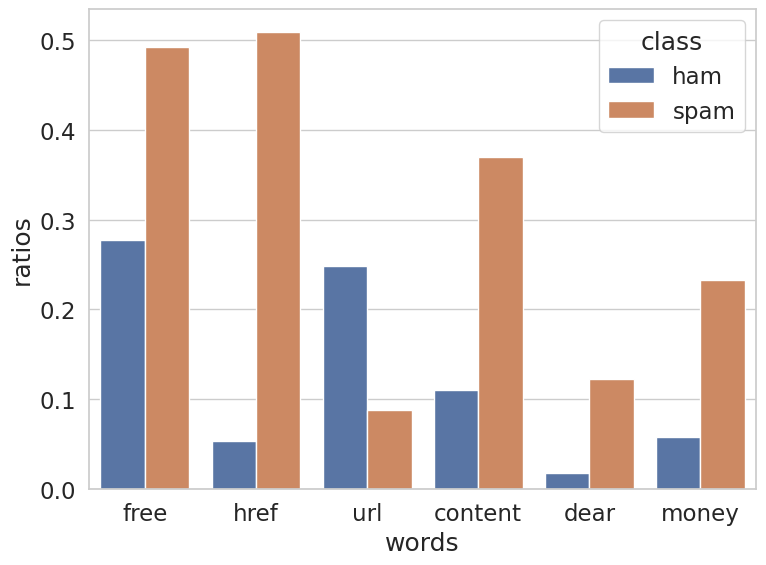

In [12]:
train = train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts.
plt.figure(figsize=(8,6))
words = ['free', 'href', 'url', 'content', 'dear', 'money']
words_pd = pd.DataFrame(words_in_texts(words, train['email']), columns = words)
words_pd['type'] = train['spam']
spam_emails = []
ham_emails = []
for word in words:
    spam_emails.append(len(words_pd.loc[(words_pd['type'] == 1) & (words_pd[word] == 1)]) / len(words_pd.loc[(words_pd['type'] == 1)]))
    ham_emails.append(len(words_pd.loc[(words_pd['type'] == 0) & (words_pd[word] == 1)]) / len(words_pd.loc[(words_pd['type'] == 0)]))
df = pd.DataFrame((ham_emails) + (spam_emails), columns=['proportions'])
df['words'] = words + words
df['class'] = ['ham'] * len(ham_emails) + ['spam'] * len(spam_emails)
sns.barplot(x='words', y = 'proportions', hue='class' , data = df)
plt.tight_layout()
plt.show()

<!-- END QUESTION -->

When the feature is binary, it makes sense to compare its proportions across classes (as in the previous question). Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes. 

<br/>
<hr style="border: 1px solid #fdb515;" />

# Part 4: Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

<br>

---

## Question 4

We've given you 5 words that might be useful as features to distinguish spam/ham emails. Use these words and the `train` `DataFrame` to create two `NumPy` arrays: `X_train` and `Y_train`. `X_train` should be a 2D array of 0s and 1s created using your `words_in_texts` function on all the emails in the training set. `Y_train` should be a vector of the correct labels for each email in the training set.

*The provided tests check that the dimensions of your design matrix ($\mathbb{X}$) are correct and that your features and labels are binary (i.e., consist only of 0s and 1s). It does not check that your function is correct; that was verified in a previous question.*

In [13]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words,  train['email'])
Y_train = np.array(train['spam'])

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 array([0, 0, 0, 0, 0]))

In [14]:
grader.check("q4")

q4 results: All test cases passed!

<br>

---
## Question 5

Now that we have matrices, we can build a model with `sklearn`! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `X_train` and `Y_train`. Then, output the model's training accuracy below. You should get an accuracy of around $0.76$.

*The provided test checks that you initialized your logistic regression model correctly.*

In [15]:
from sklearn.linear_model import LogisticRegression

my_model = LogisticRegression()
my_model.fit(X_train, Y_train)


training_accuracy = (my_model.predict(X_train) == Y_train).mean()
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


In [16]:
grader.check("q5")

q5 results: All test cases passed!

<br/>
<hr style="border: 1px solid #fdb515;" />

# Part 5: Evaluating Classifiers

That doesn't seem too shabby! But the classifier you made above isn't as good as the accuracy would make you believe. First, we are evaluating the accuracy of the model on the training set, which may provide a misleading accuracy measure. Accuracy on the training set doesn't always translate to accuracy in the real world (on the test set). In future parts of this analysis, we will make use of the data we held out for model validation and comparison.

Presumably, our classifier will be used for **filtering**, i.e., preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- **False positive (FP)**: A ham email gets flagged as spam and filtered out of the inbox.
- **False negative (FN)**: A spam email gets mislabeled as ham and ends up in the inbox.

To be clear, we label spam emails as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier in addition to overall accuracy:

**Precision**: Measures the proportion of emails flagged as spam that are actually spam. Mathematically, $\frac{\text{TP}}{\text{TP} + \text{FP}}$.

**Recall**: Measures the proportion  of spam emails that were correctly flagged as spam. Mathematically, $\frac{\text{TP}}{\text{TP} + \text{FN}}$.

**False positive rate**: Measures the proportion  of ham emails that were incorrectly flagged as spam. Mathematically, $\frac{\text{FP}}{\text{FP} + \text{TN}}$.

One quick mnemonic to remember the formulas is that **P**recision involves T**P** and F**P**, Recall does not. In the final, the reference sheet will also contain the formulas shown above, but you should be able to interpret what they mean and their importance depending on the context.

The below graphic (modified slightly from [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)) may help you understand precision and recall visually:<br />
<center>
<img alt="precision_recall" src="images/precision_recall.png" width="600px" />
</center>

Note that a True Positive (TP) is a spam email that is classified as spam, and a True Negative (TN) is a ham email that is classified as ham.

<br>

---

## Question 6a

Suppose we have a hypothetical classifier called the “zero predictor.” For any inputted email, the zero predictor *always* predicts 0 (it never makes a prediction of 1 for any email). How many false positives and false negatives would this classifier have if it were evaluated on the training set and its results were compared to `Y_train`? Assign `zero_predictor_fp` to the number of false positives and `zero_predictor_fn` to the number of false negatives for the hypothetical zero predictor on the training data.

*The public tests only check that you have assigned appropriate types of values to each response variable, but do not check that your answers are correct. That is, we only check that the number of false positives and false negatives should be greater than or equal to 0.*

In [17]:
zero_predictor_fp = 0
zero_predictor_fn = sum(Y_train == 1)
zero_predictor_fp, zero_predictor_fn

(0, 1918)

In [18]:
grader.check("q6a")

q6a results: All test cases passed!

<br>

---

## Question 6b

What is the accuracy and recall of the zero predictor on the training data? Do not use any `sklearn` functions to compute these performance metrics.

*The public tests only check that you have assigned appropriate types of values to each response variable, but do not check that your answers are correct. That is, we only check that proportions or percentages (like precision, recall, accuracy) lie in the interval [0, 1]*

In [19]:
zero_predictor_acc = sum((Y_train == 0)) / len(X_train)
zero_predictor_recall = 0
zero_predictor_acc, zero_predictor_recall

(0.7447091707706642, 0)

In [20]:
grader.check("q6b")

q6b results: All test cases passed!

<!-- BEGIN QUESTION -->

<br>

---

## Question 6c

Explain your results in Question 6a and Question 6b. How did you know what to assign to `zero_predictor_fp`, `zero_predictor_fn`, `zero_predictor_acc`, and `zero_predictor_recall`?

zero_predictor_fp was set to be zero since the zero_predictor always predicts zero since it never predicts any positives so there will be zero false positives. Since zero_predictor_fn never predicts true positives, 1918 was the total amount of spam emails that were being mislabeled as ham emails. As for accuracy, zero_predictor_acc is the proportion of ham emails out of the total number of emails that were truly ham emails. Lastly, zero_predictor_recall is set as zero as true positives never occur.  

<!-- END QUESTION -->

<br/>

---

## Question 6d

Compute the precision, recall, and false positive rate of the `LogisticRegression` classifier `my_model` from Question 5. Do **not** use any `sklearn` functions to compute performance metrics; the only `sklearn` method you may use here is `.predict` to generate model predictions using `my_model` and `X_train`.

*The public tests only check that you have assigned appropriate types of values to each response variable, but do not check that your answers are correct. That is, we only check that proportions or percentages (like precision, recall, false positive rate) lie in the interval [0, 1]*

In [21]:
Y_train_hat = my_model.predict(X_train)

TP = sum((Y_train == 1) & (Y_train_hat == 1))
TN = sum((Y_train == 0) & (Y_train_hat == 0))
FP = sum((Y_train == 0) & (Y_train_hat == 1))
FN = sum((Y_train == 1) & (Y_train_hat == 0))
logistic_predictor_precision = TP / sum(Y_train_hat == 1)
logistic_predictor_recall = TP / sum(Y_train == 1)
logistic_predictor_fpr = FP / sum(Y_train == 0)

print(f"{TP=}, {TN=}, {FP=}, {FN=}")
print(f"{logistic_predictor_precision=:.2f}, {logistic_predictor_recall=:.2f}, {logistic_predictor_fpr=:.2f}")

TP=219, TN=5473, FP=122, FN=1699
logistic_predictor_precision=0.64, logistic_predictor_recall=0.11, logistic_predictor_fpr=0.02


In [22]:
grader.check("q6d")

q6d results: All test cases passed!

<br>

---

## Question 6e

Is the number of false positives produced by the logistic regression classifier `my_model` strictly greater than the number of false negatives produced? Assign to `q6e` an expression that evaluates to give your answer (`True` or `False`). 

In [23]:
q6e = False
q6e

False

In [24]:
grader.check("q6e")

q6e results: All test cases passed!

<!-- BEGIN QUESTION -->

<br>

---

## Question 6f

How does the accuracy of the logistic regression classifier `my_model` compare to the accuracy of the zero predictor?

The accuracy obtained by my_model was 75.76% whilst the zero_predictor obtained 74.47. Thus, since its accuracy is slightly lower than my_model, my_model performed better

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

---

## Question 6g

Given the word features provided in Question 4, discuss why the logistic regression classifier `my_model` may be performing poorly. 

**Hint:** Think about how prevalent these words are in the email set.

my_model may be performing poorly due to the choice of words. There may not be significant differences in the number of times the chosen words appear in spam and ham (ex. url). In other words, for the model to perform better, the chosen words should appear a greater number of times in spam compared to ham and vice-versa.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

---

## Question 6h

Would you prefer to use the logistic regression classifier `my_model` or the zero predictor classifier for a spam filter? Why? Describe your reasoning and relate it to at least one of the evaluation metrics you have computed so far.

I would prefer to use the zero predictor classifier since even though my_model has a greater prediction accuracy compared to the zero predictor classifier as it is more beneficial to have false negatives than to have false positives. Thus, for the function of a spam filter, although the zero predictor classifier allows spam emails, it eliminates the risk of filtering out ham emails.

<!-- END QUESTION -->

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Venecia returns to congratulate you for finishing Project B1!

<img src="images/venecia.jpg" width="300" />

What's next? In Project B2, you will focus on building a spam/ham email classifier with logistic regression. You will be well-prepared to build such a model: you have considered what is in this data set, what it can be used for, and engineered some features that should be useful for prediction.

Below, you will see two cells. Running the first cell will automatically generate a PDF of all questions that need to be manually graded, and running the second cell will automatically generate a zip with your autograded answers. **You are responsible for both the coding portion (the zip from Project B1) and the written portion (the PDF from Project B1) to their respective Gradescope portals.** The coding proportion should be submitted to **Project B1 Coding** as a single zip file, and the written portion should be submitted to **Project B1 Written** as a single PDF file. When submitting the written portion, **please ensure you select pages appropriately**. 

If there are issues with automatically generating the PDF, you can try downloading the notebook as a PDF by clicking on `File -> Save and Export Notebook As... -> PDF`. If that doesn't work either, you can manually take screenshots of your answers to the manually graded questions and submit those. Either way, **you are responsible for ensuring your submission follows our requirements, we will NOT be granting regrade requests for submissions that don't follow instructions.**

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

After you have run the cell below and generated the zip file, you can open the PDF <a href='projB1.pdf' download>here</a>.

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)